In [158]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import prettytable as pt
%run helpers_preproc.ipynb
%matplotlib widget

# Hyper Parameters

In [159]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/'
K = 5
radiuss = [0.0002,0.0004,0.0008]
train_size = 450 * len(radiuss)
test_size = (600-450) * len(radiuss)

# 1. expand dataset and scramble

In [160]:
expand(origDataDir, newDataDir, radiuss)
scramble(newDataDir, 10000,600 * len(radiuss))

# 2. read in the dataset

## 2.1 read in v (252 x 3),f (...x...) and cluster

In [161]:
ver_list = []
adj_list = []
Nadj_list = []
gMat_list = []
gLbl_list = []

for i in range(600 * len(radiuss)):
    v, f = get_nodes(newDataDir + 'T' + str(i) + '.obj')
    group_mat, group_labels = K_mean_cluster(v, K)
    
    adj = get_adj_from_f(f)            
    normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
    ver_list.append(v)
    adj_list.append(adj)
    Nadj_list.append(normed_adj)
    gMat_list.append(group_mat)
    gLbl_list.append(group_labels)
    
    
vers = np.array(ver_list)
adjs = np.array(adj_list)
Nadjs = np.array(Nadj_list)
gMats = np.array(gMat_list)
gLbls = np.array(gLbl_list)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_14613/2399023897.py:12: RuntimeWarning: invalid value encountered in true_divide
  normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])


## 2.2 Read in the labels

In [162]:
label_np = np.array(readLbl(600 * len(radiuss),newDataDir+'labels.txt'))
label_np_train = label_np[:train_size]
label_np_test = label_np[train_size:]

## 2.3 Split into training set and testing set

In [6]:
vers_train = torch.tensor(vers[:train_size]).float()
adjs_train = torch.tensor(adjs[:train_size]).float()
nadjs_train = torch.nan_to_num(torch.tensor(Nadjs[:train_size]).float(),0,0,0)
gMats_train = torch.tensor(gMats[:train_size]).float()
label_train = torch.tensor(label_np_train).float()

vers_test = torch.tensor(vers[train_size:]).float()
adjs_test = torch.tensor(adjs[train_size:]).float()
nadjs_test = torch.nan_to_num(torch.tensor(Nadjs[train_size:]).float(),0,0,0)
gMats_test = torch.tensor(gMats[train_size:]).float()
label_test = torch.tensor(label_np_test).float()

label_mat_train = torch.tensor(np.where(igl.all_pairs_distances(label_np_train,label_np_train,False) > 0.5,0,1)).float()
label_mat_test = torch.tensor(np.where(igl.all_pairs_distances(label_np_test,label_np_test,False) > 0.5,0,1)).float()

In [164]:
#detect_nan(label_mat_train)

In [165]:
#label_mat_train

In [166]:
#print message about training and testing dataset
# print(vers_train.shape)
# print(adjs_train.shape)
# print(nadjs_train.shape)
# print(gMats_train.shape)

# 3. Training

## 3.1 Hyperparameters for training

In [10]:
contraGWs = [5,5,5,5]
contraMWs = [5,5,5,5]
atkGWs = [5,5,5,5]
atkMWs = [5,5,5,K * 3 + 1]

## 3.2 Initialize neural networks

In [84]:
%run NNs.ipynb
%run helpers_preproc.ipynb
contraG = GCN(3,contraGWs)
contraM = MLP(252* contraGWs[len(contraGWs)-1],contraMWs)
atkG = GCN(3,atkGWs)
atkM = MLP_atk(252* atkGWs[len(contraGWs)-1], 10, K, atkMWs)

## 3.4 Extract node-level features from clean data

In [85]:
feas_clean = extract_node_feature(vers_train,adjs_train)

In [86]:
%run L.ipynb

## 3.5 Feed clean data into contraNN🤠

## 3.6 Train atkNN😈 with contraNN🤠

In [87]:
atkLR = 0.0001
contraLR = 0.0001
torch.set_printoptions(precision=10)

In [89]:
#get clean features
feas_clean = extract_node_feature(vers_train,adjs_train) #grad on nothing
opt = optim.Adam(atkG.weights + atkM.weights + contraG.weights + contraM.weights, lr = 0.001)

for contraI in range(100):
    trainLog = pt.PrettyTable()
    trainLog.field_names = [" ","Loss", "Same Mean", "Diff Mean", "Same STD"]
    
    
    opt.zero_grad()

    #get poisoned vertex locations
    poisonsByGroups = atkM.forward(atkG.forward(nadjs_train,feas_clean))
    transformation = translate_by_group(gMats_train,
                                        poisonsByGroups)
    poisonedVers = vers_train + transformation
        
        
    #extract poisoned features
    feas_poisoned = extract_node_feature(poisonedVers,adjs_train) #grad on 😈

    
    #get contraNN's performance on poisoned feature with grads on 😈    
    contraM.eval()
    contraG.eval()
    aPerfPoisoned, APP = loss(contraM.forward(contraG.forward(nadjs_train,feas_poisoned)),
                         label_mat_train) #grad on 😈
    
    #get contraNN's performance on clean feature and poisoned feature with grads on 🤠
    contraM.train()
    contraG.train()
    feas_poisoned_nograd = feas_poisoned.detach() #grad on nothing
    
    objFeasFromClean = contraM.forward(contraG.forward(nadjs_train,feas_clean))
    objFeasFromPoisoned = contraM.forward(contraG.forward(nadjs_train,feas_poisoned_nograd))
    
    diffInFeas = torch.sum((objFeasFromClean - objFeasFromPoisoned)**2)
    
    cPerfClean, CPC = loss(objFeasFromClean,
                      label_mat_train) #grad on 🤠
    
    cPerfPoisoned, CPP = loss(objFeasFromPoisoned,
                         label_mat_train) #grad on 🤠
    
    
    trainLog.add_row(['On Clean Data']+CPC)
    trainLog.add_row(['On Poisoned Data']+CPP)

    
    overallLoss = -aPerfPoisoned + cPerfClean + cPerfPoisoned#  + diffInFeas
    overallLoss.backward()
    opt.step()
    
    print(trainLog)
    
    

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.28488 |  0.44845  |  0.78318  | 2.49189  |
| On Poisoned Data | -0.13987 |  0.31523  |   0.4901  | 1.74997  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.19289 |  0.28292  |   0.5075  | 1.58445  |
| On Poisoned Data | -0.05171 |  0.12788  |  0.19412  | 0.72669  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.0005  |  0.00138  |  0.00205  | 0.00814  |
| On Poisoned Data | -0.00021 |  0.00192  |  0.00235  | 0.01086  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.00048 |  0.00135  |  0.00199  | 0.00798  |
| On Poisoned Data | -0.0002  |  0.00188  |  0.00229  | 0.01064  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

KeyboardInterrupt: 

## 3.7 Seeing how it does on Test Data

In [82]:
feas_clean_test = extract_node_feature(vers_test,adjs_test)

atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))

poisonedVersTest = vers_test + translate_by_group(gMats_test,atkTest)
        
feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)
        
contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))
contraLossPoisonedTest,_ = loss(contraOutPoisonedTest,label_mat_test)

contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))
contraLossCleanTest,_ = loss(contraOutCleanTest,label_mat_test)

print(contraLossPoisonedTest)
print(contraLossCleanTest)

tensor(-0.5182853341, grad_fn=<AddBackward0>)
tensor(-0.5151064396, grad_fn=<AddBackward0>)


In [117]:
plt.clf()

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_14679/1998953040.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat - torch.diag(torch.ones(size)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_14679/1998953040.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()


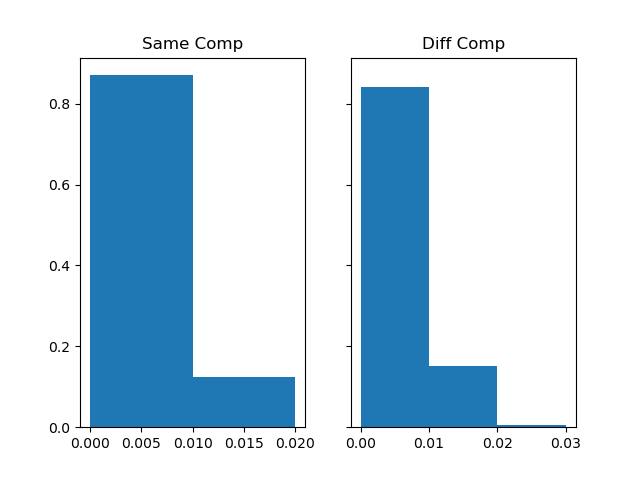

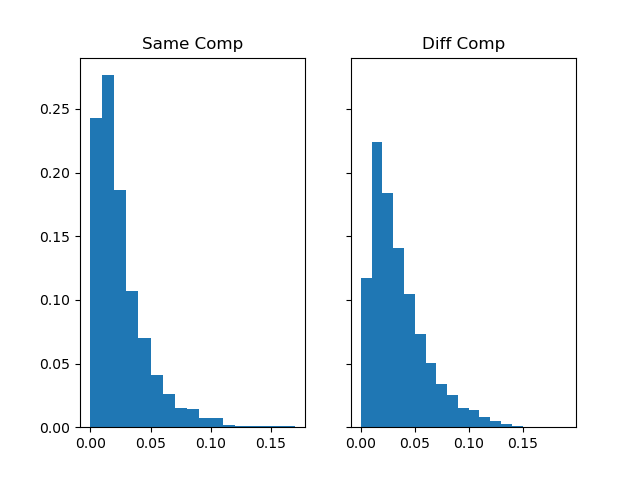

In [128]:
feas_clean_test = extract_node_feature(vers_test,adjs_test)

atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))

poisonedVersTest = translate_by_group(vers_test,gMats_test,atkTest)

feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)

contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))
contraLossPoisonedTest = lossAtkF(contraOutPoisonedTest,label_mat_test)

contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))
contraLossCleanTest = lossContraF(contraOutCleanTest,label_mat_test)

#display histograms
display_hist(contraOutPoisonedTest, label_mat_test, test_size)
display_hist(contraOutCleanTest, label_mat_test, test_size)

In [ ]:
plt.clf()

In [ ]:
from mpl_toolkits.mplot3d import axes3d


index_in_question = 1

#Plot first clustered mesh
dataPlot = vers[index_in_question]

fig = plt.figure()
ax = fig.add_subplot(121,projection='3d')

ax.scatter(dataPlot[:,0], dataPlot[:,1], dataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis',s = 3)
ax.set_title('clean')

plt.axis('off')

#Plot second clustered point coud
#get poison
atkOut = atkM.forward(atkG.forward(nadjs_train,feas_clean))
poisonedVers = translate_by_group(vers_train,gMats_train,atkOut).detach().numpy()

print(poisonedVers.shape)
#poisioedVers = np.zeros([1350,252,3])
poisonedDataPlot = vers[index_in_question] + poisonedVers[index_in_question]

ax = fig.add_subplot(122,projection='3d')

ax.scatter(poisonedDataPlot[:,0], poisonedDataPlot[:,1], poisonedDataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis', s = 3)
ax.set_title('poisoned')

plt.axis('off')

plt.show()

In [ ]:
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
# ax.axes.zaxis.set_ticklabels([])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')